In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
ticker = 'HD'
start_date = '2010-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
print(data.head(10))

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open    Volume
Ticker             HD         HD         HD         HD         HD        HD
Date                                                                       
2010-01-04  19.933249  28.670000  29.150000  28.549999  29.150000  13120900
2010-01-05  20.079250  28.879999  28.990000  28.290001  28.730000  15594300
2010-01-06  20.009727  28.780001  29.000000  28.700001  28.879999   8833200
2010-01-07  20.246115  29.120001  29.219999  28.730000  28.860001  12058200
2010-01-08  20.148779  28.980000  29.240000  28.690001  29.000000  15609800
2010-01-11  19.578659  28.160000  29.020000  28.080000  29.000000  23670500
2010-01-12  19.453510  27.980000  28.350000  27.889999  28.150000  23075800
2010-01-13  19.557802  28.129999  28.250000  28.000000  28.000000  15639100
2010-01-14  19.675999  28.299999  28.440001  28.120001  28.120001  13208200
2010-01-15  19.863724  28.570000  28.690001  28.000000  28.309999  23013500


# Step 3.1 Compute the classical historical mean and volatility estimators (as referenced in equations (9) and (14) in your notes).

In [8]:
ticker = 'HD'
start_date = '2010-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
print(data.head(10))

# calculate log-return
data['LogReturn'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
log_returns = data['LogReturn'].dropna()

# N is length of log-return 
N = len(log_returns)

# eq 9: drift (mean of log-return)
mu_hat = log_returns.mean()

# eq 14: variance of log-return
sigma2_hat = ((log_returns - mu_hat)**2).sum() / (N - 1)

# mean and volatility per day
print(f"N = {N} days")
print(f"μ_hat (mean of log-return) ≈ {mu_hat:.6f} per day")
print(f"σ²_hat (variance of log-return) ≈ {sigma2_hat:.6f} per day²")
print(f"σ_hat (volatility) ≈ {np.sqrt(sigma2_hat):.6f} per day")

# annualize the drift and volatility
trading_days = 252
mu_annual = mu_hat * trading_days
sigma2_annual = sigma2_hat * trading_days
sigma_annual = np.sqrt(sigma2_annual)

# annualized mean and volatility
print(f"μ_hat ≈ {mu_annual:.6f} per year (annualized drift)")
print(f"σ²_hat ≈ {sigma2_annual:.6f} per year² (annualized variance)")
print(f"σ_hat ≈ {sigma_annual:.6f} per year (annualized volatility)")


[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open    Volume
Ticker             HD         HD         HD         HD         HD        HD
Date                                                                       
2010-01-04  19.933249  28.670000  29.150000  28.549999  29.150000  13120900
2010-01-05  20.079250  28.879999  28.990000  28.290001  28.730000  15594300
2010-01-06  20.009727  28.780001  29.000000  28.700001  28.879999   8833200
2010-01-07  20.246115  29.120001  29.219999  28.730000  28.860001  12058200
2010-01-08  20.148779  28.980000  29.240000  28.690001  29.000000  15609800
2010-01-11  19.578659  28.160000  29.020000  28.080000  29.000000  23670500
2010-01-12  19.453510  27.980000  28.350000  27.889999  28.150000  23075800
2010-01-13  19.557802  28.129999  28.250000  28.000000  28.000000  15639100
2010-01-14  19.675999  28.299999  28.440001  28.120001  28.120001  13208200
2010-01-15  19.863724  28.570000  28.690001  28.000000  28.309999  23013500
N = 3840 day

# 3.2 Compute a rolling window estimator using a 30-day window. Plot the results for all estimators and explain your findings

[*********************100%***********************]  1 of 1 completed


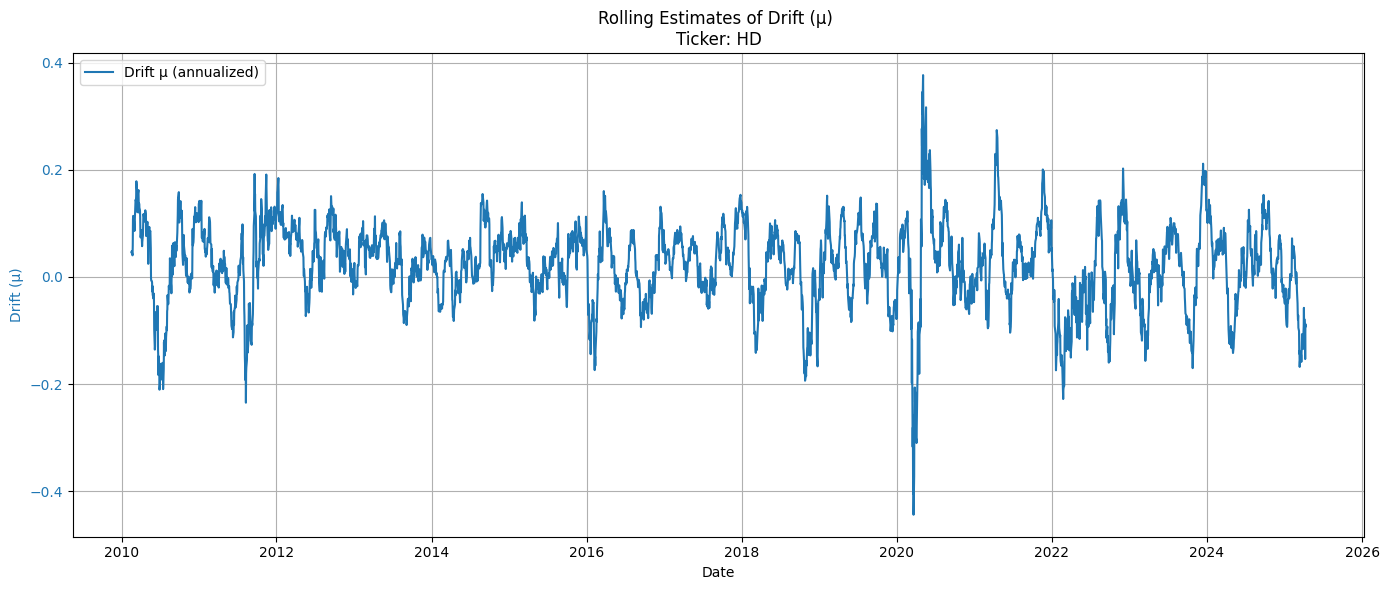

In [48]:
def sigma2_from_eq15(log_returns, N = 252, delta_t=1/252):
    if log_returns.isnull().any():
        return np.nan

    T = N * delta_t

    # μ̂_N
    mu_hat = log_returns.mean() / delta_t

    # Σ r_k^2
    sum_squared_returns = (log_returns ** 2).sum()

    # finally, we can calculate σ²̂_N
    sigma2_hat = (1 / ((N - 1) * delta_t)) * sum_squared_returns - (T / (N - 1)) * mu_hat**2
    return sigma2_hat

def sigma2_parkinson(high: pd.Series, low: pd.Series):
    """
    Parkinson estimator of variance.
    
    Parameters:
    - high: Series of daily high prices
    - low: Series of daily low prices
    - delta_t: time increment (default assumes daily data with 252 trading days/year)

    Returns:
    - Estimated annualized variance using Parkinson formula
    """
    # if (high.isnull().any()) or (low.isnull().any()):
    #     return np.nan

    log_hl = np.log(high / low)
    sigma2 = (1 / (4 * np.log(2))) * np.sum(log_hl ** 2)
    return sigma2

def compute_rolling_sigma2_parkinson(data: pd.DataFrame, window: int) -> pd.Series:
    """
    Computes rolling sigma² using Parkinson's estimator over the entire time series.

    Parameters:
    - data: pd.DataFrame with columns 'High' and 'Low'
    - window: rolling window size (int)

    Returns:
    - pd.Series of rolling sigma² values (same index as `data`)
    """
    result = [np.nan] * (window - 1)
    
    for i in range(window - 1, len(data)):
        window_high = data['High'].iloc[i - window + 1: i + 1]
        window_low = data['Low'].iloc[i - window + 1: i + 1]
        sigma2 = sigma2_parkinson(window_high, window_low)
        result.append(sigma2)
    
    return pd.Series(result, index=data.index)

def sigma2_garman_klass(high: pd.Series, low: pd.Series, open_: pd.Series, close: pd.Series):
    """
    Garman-Klass estimator of variance.

    Parameters:
    - high: Series of daily high prices
    - low: Series of daily low prices
    - open_: Series of daily open prices
    - close: Series of daily close prices
    - delta_t: time increment (default assumes daily data with 252 trading days/year)

    Returns:
    - Estimated annualized variance using Garman-Klass formula
    """
    # if any(s.isnull().any() for s in [high, low, open_, close]):
    #     return np.nan

    T = len(high)
    log_hl = np.log(high / low)
    log_oc = np.log(close / open_)

    term1 = (1 / (2 * T)) * np.sum(log_hl ** 2)
    term2 = ((2 * np.log(2) - 1) / T) * np.sum(log_oc ** 2)

    sigma2 = (term1 - term2)
    return sigma2

def compute_rolling_sigma2_garman_klass(data: pd.DataFrame, window: int) -> pd.Series:
    """
    Computes rolling sigma² using Garman-Klass estimator over the entire time series.

    Parameters:
    - data: pd.DataFrame with columns 'High', 'Low', 'Open', 'Close'
    - window: rolling window size (int)

    Returns:
    - pd.Series of rolling sigma² values (same index as `data`)
    """
    result = [np.nan] * (window - 1)
    
    for i in range(window - 1, len(data)):
        window_high = data['High'].iloc[i - window + 1: i + 1]
        window_low = data['Low'].iloc[i - window + 1: i + 1]
        window_open = data['Open'].iloc[i - window + 1: i + 1]
        window_close = data['Close'].iloc[i - window + 1: i + 1]
        sigma2 = sigma2_garman_klass(window_high, window_low, window_open, window_close)
        result.append(sigma2)
    
    return pd.Series(result, index=data.index)

# Downloading the data
ticker = 'HD'
start_date = '2010-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

N = 30 # Number of trading in 30 days
delta_t = 1 / N # Time increment in months

data['LogReturn'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
data['RollingMu'] = data['LogReturn'].rolling(window=N).mean() / delta_t  # see equation (10) in the appendix

# plotting the results
fig, ax1 = plt.subplots(figsize=(14, 6))
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Drift (μ)', color=color)
ax1.plot(data.index, data['RollingMu'], color=color, label='Drift μ (annualized)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
# formatting the plot
plt.title(f"Rolling Estimates of Drift (μ) \nTicker: {ticker}")
fig.tight_layout()
plt.grid(True)
plt.show()


d:\code-repo\作业\cf_assignment1\assignment1\zxx\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\alex\AppData\Local\Temp\ipykernel_11892\1858268509.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  data['Sigma2_parkinson'] = compute_rolling_sigma2_parkinson(data, window=N).astype(float)
d:\code-repo\作业\cf_assignment1\assignment1\zxx\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out

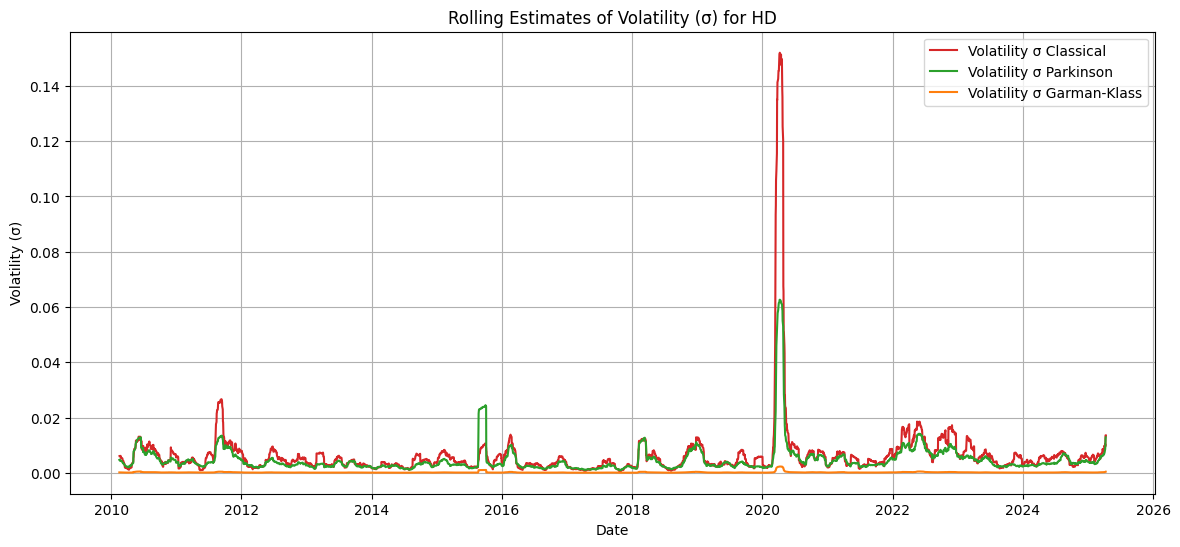

In [ ]:
# # Here Y: σ² (volatility)
# color = 'tab:red'
# ax1.set_ylabel('Realized Volatility σ²', color=color)
# ax1.plot(data.index, data['Sigma2_rolling'], color=color, label='Volatility σ² Classical', alpha=0.7)
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(loc='upper right')

# color = 'tab:green'
# ax2.set_ylabel('Realized Volatility σ²', color=color)
# ax2.plot(data.index, data['Sigma2_parkinson'], color=color, label='Volatility σ² Parkinson', alpha=0.7)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend(loc='upper right')

# # formatting the plot
# plt.title(f"Rolling Estimates of Drift (μ) and Realized Volatility (σ²)\nTicker: {ticker}")
# fig.tight_layout()
# plt.grid(True)
# plt.show()

# classic volatility
data['Sigma2_rolling'] = data['LogReturn'].rolling(window=N).apply(sigma2_from_eq15, args=(N, delta_t), raw=False)
data['Sigma_rolling'] = np.sqrt(data['Sigma2_rolling'])

# Parkinson volatility
data['Sigma2_parkinson'] = compute_rolling_sigma2_parkinson(data, window=N).astype(float)
data['Sigma_parkinson'] = np.sqrt(data['Sigma2_parkinson'])

# Garman-Klass volatility
data['Sigma2_garman_klass'] = compute_rolling_sigma2_garman_klass(data, window=N).astype(float)
data['Sigma_garman_klass'] = np.sqrt(data['Sigma2_garman_klass'])

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Sigma2_rolling'], label='Volatility σ2 Classical', color='tab:red')
plt.plot(data.index, data['Sigma2_parkinson'], label='Volatility σ2 Parkinson', color='tab:green')
plt.plot(data.index, data['Sigma2_garman_klass'], label='Volatility σ2 Garman-Klass', color='tab:orange')
plt.title(f"Rolling Estimates of Volatility (σ2) for {ticker}")
plt.xlabel('Date')
plt.ylabel('Volatility (σ2)')
plt.legend()
plt.grid(True)
plt.show()
